In [548]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
from zipfile import ZipFile, ZIP_DEFLATED


In [549]:

np.random.seed(42) # for reproducibility
num_repetitions = 10000
num_xs = 500
x = np.linspace(0, 10, num_xs)
dataset_type = 'largedataset'

signals = np.zeros((num_repetitions, len(x)))
gauss_parameters = []


In [550]:
all_peaks = []

In [551]:
binary_peaks = np.zeros((num_repetitions, num_xs))

In [552]:
for i in range(num_repetitions):
    n_gauss = np.random.randint(25, 50)
    signal = np.zeros(num_xs, )
    parameters = []
    peaks = []

    min_d = 0.08
    used_means = []

    for _ in range(n_gauss):
        attempts = 0
        while True:
            mean = np.random.uniform(1, 8)
            if all(abs(mean - m) >= min_d for m in used_means):
                used_means.append(mean)
                break
            attempts += 1
            if attempts > 80: # avoid inf loop
                break

        amp = np.random.uniform(0.5, 1.5)
        std_dev = np.random.uniform(0.05,0.2)

        gauss = amp * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))
        signal += gauss
        parameters.append((amp, mean, std_dev))

        peak_index = np.argmax(gauss)
        peaks.append(peak_index)
        binary_peaks[i][peak_index] = 1

    signals[i] = signal
    gauss_parameters.append(parameters)
    all_peaks.append(peaks)

In [553]:
for i in range(num_repetitions):
    for idx in all_peaks[i]:
        binary_peaks[i][idx] = 1

In [554]:
binary_peaks[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [555]:
all_peaks[0]

[np.int64(328),
 np.int64(258),
 np.int64(210),
 np.int64(277),
 np.int64(378),
 np.int64(266),
 np.int64(58),
 np.int64(66),
 np.int64(82),
 np.int64(393),
 np.int64(288),
 np.int64(247),
 np.int64(131),
 np.int64(341),
 np.int64(114),
 np.int64(123),
 np.int64(188),
 np.int64(164),
 np.int64(386),
 np.int64(238),
 np.int64(146),
 np.int64(198),
 np.int64(298),
 np.int64(373),
 np.int64(347),
 np.int64(179),
 np.int64(184),
 np.int64(139),
 np.int64(89),
 np.int64(363),
 np.int64(293)]

In [556]:
np.argmax(signals[0], axis=0)

np.int64(184)

In [557]:
peak_indices = []

In [558]:
ds = xr.Dataset(
    {
        "Gaussians": (["pattern", "x"], signals),
        "BinaryArr": (["pattern", "x"], binary_peaks)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": x
    }
)

In [559]:
gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values


In [560]:
%matplotlib inline

In [561]:
plt.close()

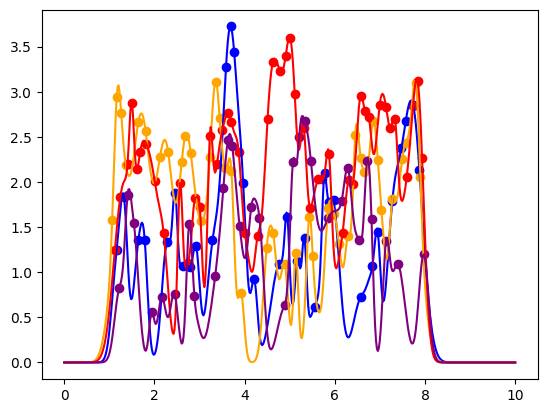

In [562]:
plt.figure()
colors = ['blue', 'orange', 'red', 'purple', 'green']
for i in range(4):
    plt.plot(x, signals[i], color=colors[i])
    plt.scatter(x[all_peaks[i]], signals[i][all_peaks[i]], color=colors[i])
plt.show()

In [563]:
ds = xr.Dataset(
    {
        "Gaussians": (["pattern", "x"], signals),
        "BinaryArr": (["pattern", "x"], binary_peaks)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": x
    }
)


In [564]:
path = '../saved_data/'
file = f'math_functions_{dataset_type}.nc'

ds.to_netcdf(os.path.join(path, file))
with ZipFile(os.path.join(path,file.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file), arcname=file)


In [565]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import entropy

In [566]:
ds = xr.open_dataset(path + file)

In [567]:
gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values
x = ds["x"].values
peak_idx = np.where(binary == 1)

In [568]:
random_state = 42

In [569]:
# Split data into train and test sets
gauss_train, gauss_test, binary_train, binary_test = train_test_split(gaussians, binary, test_size=0.2, random_state=random_state)

In [570]:
# Scale the features (the intensity values)
scaler = StandardScaler() # create the scaler object 

gauss_train = scaler.fit_transform(gauss_train)
gauss_test = scaler.transform(gauss_test)

In [571]:
from sklearn.utils.class_weight import compute_sample_weight
# sample_weights = compute_sample_weight(class_weight='balanced', y=binary_train)

In [ ]:
# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(400), max_iter=2000, random_state=random_state, verbose=True,
                   learning_rate_init=0.005,  # Default is 0.001; can increase or decrease
                    tol=1e-5,
                   early_stopping=False)

In [581]:
# Train the MLP classifier
mlp.fit(gauss_train, binary_train)

Iteration 1, loss = 142.36970950
Iteration 2, loss = 117.12935092
Iteration 3, loss = 115.02033519
Iteration 4, loss = 114.02005465
Iteration 5, loss = 113.49899127
Iteration 6, loss = 113.02353238
Iteration 7, loss = 112.50907961
Iteration 8, loss = 112.10508825
Iteration 9, loss = 111.91173565
Iteration 10, loss = 111.63309662
Iteration 11, loss = 111.40599288
Iteration 12, loss = 111.17377595
Iteration 13, loss = 110.94795821


/nsls2/users/shasko/conda_envs/internship/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:787: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


,hidden_layer_sizes,200
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.005
,power_t,0.5
,max_iter,2000
,shuffle,True
,random_state,42


In [ ]:
binary_pred = mlp.predict(gauss_test) # make predictions

In [ ]:
probs = mlp.predict_proba(gauss_test)

In [ ]:
two_classprobs = np.array([[i,1-i] for i in probs]) # 1-i will give probability for the 0 class
two_classprobs = two_classprobs.reshape((probs.shape[0],probs.shape[1],2)) # reshape to (num_samples, num_features, num_classes)

In [ ]:
confidences = []
for i in range(two_classprobs.shape[0]):
    confidence = np.max(two_classprobs[i], axis=1) # returns max value for each of the features
    confidences.append(confidence)
confidences = np.array(confidences)

In [ ]:
uncertainties = []
for i in range(two_classprobs.shape[0]):
    uncertainties.append(entropy(two_classprobs[i].T))
uncertainties = np.array(uncertainties)

(array([ 76,  78,  88,  95,  98, 116, 118, 188, 190, 191, 215, 281, 284,
       289, 326, 329, 330, 331, 333, 348, 390, 392, 399]),)
(array([ 51,  65, 122, 140, 143, 161, 162, 167, 171, 185, 189, 218, 219,
       233, 267, 272, 300, 302, 308, 311, 352, 353, 354, 360]),)
(array([ 61,  62,  63,  88,  92, 103, 106, 114, 129, 131, 134, 139, 171,
       236, 259, 283, 342, 347]),)


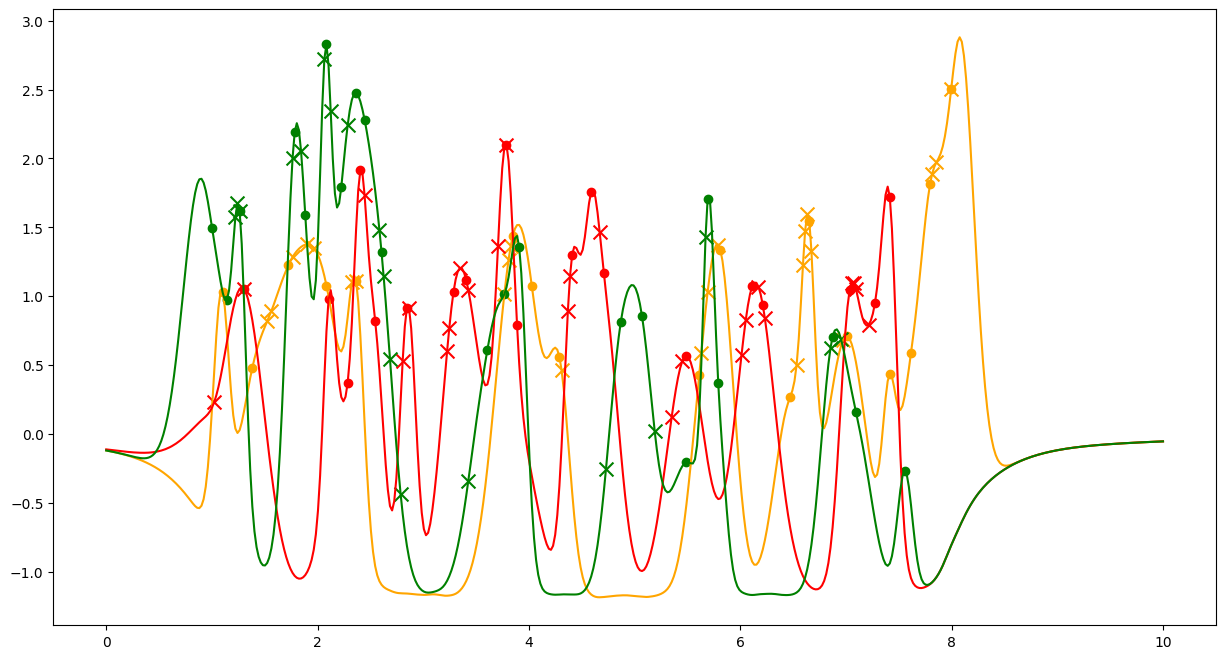

In [ ]:
plt.close()
# plt.scatter(x, uncertainties)
# plt.scatter(x, confidences)

plt.figure(figsize=(15,8))
colors = ['orange', 'red', 'green']

for i in range(3):
    
    idx_true = np.where(binary_test[i] == 1)
    plt.scatter(x[idx_true], gauss_test[i][idx_true], marker='o', color=colors[i])
    plt.plot(x, gauss_test[i], color=colors[i])

    idx = np.where(binary_pred[i] == 1)
    print(idx)
    plt.scatter(x[idx], gauss_test[i][idx], marker='x', s = 100, color=colors[i])
  
    
   
plt.show()